# ASTR 596: FDS Homework 6+7: Gaussian Processes (200 pts)

### This is a double HW set so you get extra time - until reading day (May 4th, 2023) at noon to do it. 
### After that, it's finals time. 


# P1. Gaussian Processes

### Last HW, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [1]:
%matplotlib notebook
%pylab

from astropy.table import Table
import scipy.stats as st
import sklearn
import sklearn.ensemble

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [105]:
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

time,flux,error,quarter
float64,float64,float64,int64
539.4710179205795,5221.16455078125,4.891251087188721,6
539.4914521464307,5216.07958984375,4.892819404602051,6
539.5118864718097,5225.43359375,4.891888618469238,6
539.5323205971945,5233.111328125,4.892074108123779,6
539.5527548221144,5221.17333984375,4.891964435577393,6
539.573189147035,5220.09521484375,4.891523361206055,6
539.5936232714812,5222.14208984375,4.893854141235352,6
539.6140574957026,5224.57958984375,4.893648147583008,6
539.6344918194518,5223.78564453125,4.894421100616455,6


In [106]:
qs = sorted(np.unique(tab['quarter']))
plt.figure()
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False);


<IPython.core.display.Javascript object>

### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations. (20 pts)

In [6]:
from george import kernels

### Q2: To implement the full model, read how to use `george`'s modeling protocol: (20 pts)
https://george.readthedocs.io/en/latest/tutorials/model/

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots) (20 pts)

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps) (20 pts)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help 

### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black.  (20 pts)

# P2. Random Forests

For this work, we'll use the datasets produced by [Dey et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.515.5285D/abstract), who trained a deep capsule network on postage stamps of SDSS galaxies to predict photometric redshifts. 

We're not going to use a deep capsule network on postage stamps, but we can use tabular data. This won't be as performant, but it's still instructive to see how well we can do with a simple random forest. Dey et al. have done an excellent job making their data available - http://d-scholarship.pitt.edu/42023/ (all of it)

You will need the [training set](http://d-scholarship.pitt.edu/42023/9/cat_train.csv) and the [test set](http://d-scholarship.pitt.edu/42023/8/cat_test.csv).

I suggest reading through Sec. 2 of the paper to get some sense of what the data is. Importantly, the data includes columns for photometric redshift already. You can't use these to train your random forest (duh.). I've limited the number of columns you can use to a set defined below. If you use more than these (e.g. the GalaxyZoo parameters) you might get better performance at the cost of a smaller training sample because you've also got to filter missing data. 

In [1]:
train_cols = ['dered_petro_u', 'dered_petro_g', 'dered_petro_r', 'dered_petro_i', 'dered_petro_z',\
       'petroMagErr_u', 'petroMagErr_g', 'petroMagErr_r', 'petroMagErr_i', 'petroMagErr_z',\
       'v_disp', 'sersicN_r', 'petroR90_r']
pred_cols  = ['z', 'zErr', 'zphot', 'dzphot'] # was told by my peers (Liam) to remove bestObjID from the pred cols for a better fit, so i'm trying it

### Q6. Pre-process the data

All ML work involves some amount of cleaning and pre-processing the data.
Filter data that have `zphot_reliable` == `True`, and have redshifts and photo-zs >= 0. 
Next filter any entries in the `train_cols` that have any value that is > 5 $\times$ the nomrally-scaled Median Absolute Deviation (as described in Sec 2.3) (`scipy.stats.median_abs_deviation` is your friend). 
Your pre-processed training data should have 357397 entries.
Make a hexbin plot of `zphot` vs `z` for the training data (to avoid plotting that many points) but replicate Fig. 3 in Dey et al. 
(35 pts)

In [47]:
# import some packages, i'll import more later

import pandas as pd
import numpy as np
from scipy.stats import median_abs_deviation

# import data

training_set = pd.read_csv('cat_train.csv')
test_set = pd.read_csv('cat_test.csv')

In [48]:
# Filter out based on zphot, also filter all the weird redshift values out

training_set = training_set[training_set['zphot_reliable']==True]
training_set = training_set[training_set['z'] >=0 ]
training_set = training_set[training_set['zphot'] >= 0]

# Drop rows w nans from the columns

training_set.dropna(subset = train_cols, inplace=True)

# filter outliers out of data (if I do > 5*MAD, i get no data, so i interpreted this as the other way)

for n in train_cols:

    print(training_set.shape)
    training_set = training_set[np.abs(training_set[n] - np.median(training_set[n])) < (5 * 1.4826 * median_abs_deviation(training_set[n]))]

# I note that this way I get 354365 galaxies, not 357397 galaxies. Close enough

(409202, 121)
(406424, 121)
(405960, 121)
(403804, 121)
(403358, 121)
(403266, 121)
(386453, 121)
(371145, 121)
(362640, 121)
(358897, 121)
(354723, 121)
(354365, 121)
(354365, 121)


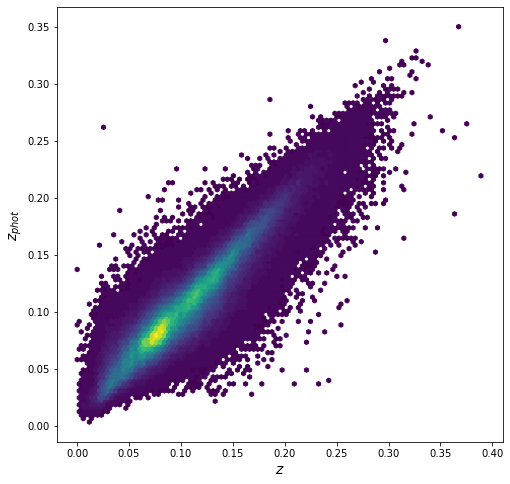

In [49]:
import matplotlib.pyplot as plt

# Well the point was to recreate Fig. 3, so here it is

plt.figure(figsize=[8,8])
plt.hexbin(training_set.z, training_set.zphot, mincnt=1, bins=50)
plt.xlabel(r'$z$', fontsize=14)
plt.ylabel(r'$z_{phot}$', fontsize=14)
plt.show()

### Q7. Train the forest(s)

Using `n_estimators` (i.e. number of trees) in (5, 20, 50, 200, 500), train a random forest. You can use all the cores your CPU has with `n_jobs=-1`. Limit the maximum number of features at each branch with `sqrt`. Use the inverse variance of the redshifts as your sample weights. Plot the `oob_score` vs the number of trees. For each of the forests you trained, make a plot of the feature importances. (35 pts)

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


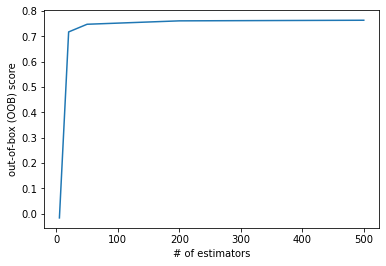

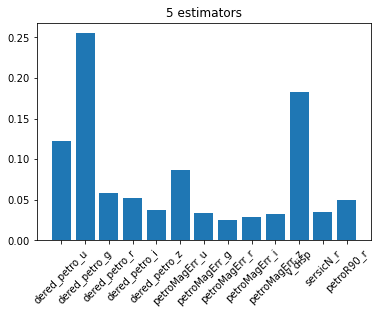

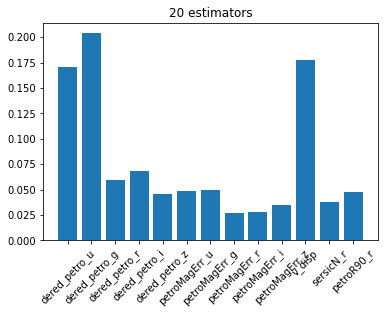

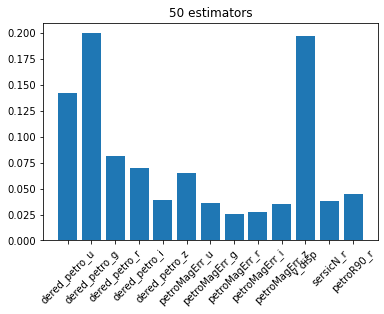

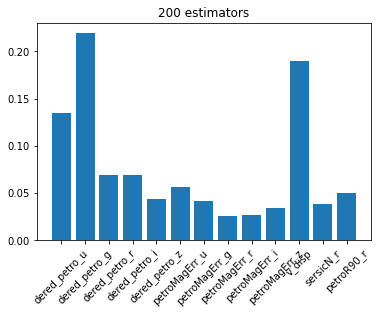

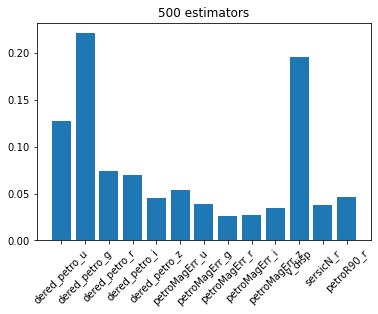

In [50]:
# import Random Forest package

from sklearn.ensemble import RandomForestRegressor

n_estimators_vals = [5, 20, 50, 200, 500] # estimators given from prompt

# want predicted columns to be determined as a function of the training columns

x = training_set[train_cols]
y = training_set[pred_cols]

# create arrays for plot generation

oob_score = []
features = []

for n in n_estimators_vals:
    rf = RandomForestRegressor(n_estimators=n, max_features='sqrt', n_jobs=-1, oob_score=True)
    rf.fit(x, y, sample_weight=(1.0 / y.zErr)**2) # weights are inverse variance of 
                                                  # redshifts, as requested
    oob_score.append(rf.oob_score_)
    features.append(rf.feature_importances_)

# Plotting OOB score vs. number of trees

plt.plot(n_estimators_vals, oob_score)
plt.xlabel('# of estimators')
plt.ylabel('out-of-box (OOB) score')
plt.show()

# Plotting feature importances

for n, n_estimators in enumerate(n_estimators_vals):
    plt.bar(x.columns, features[n])
    plt.xticks(rotation=45)
    plt.title('{} estimators'.format(n_estimators))
    plt.show()

### Q8. Test.

Pick your best performing forest from Q7. Load the test data (remember to apply any cuts you did to the training data). Use your random forest to predict the photo-z. Replicate Fig. 3 and Fig. 4 with your photo-z prediction *and* the photo-z prediction from SDSS included in the file. (30 pts, 10 pts for prediction, 10 for the two figures)

In [51]:
# combing for best forest

best_score = np.argmax(oob_score) # highest out-of-bag score --> lowest error on model 
best_estimators = n_estimators_vals[best_score]
print(best_estimators)

# using best forest (i think 500 trees)

final_rf = RandomForestRegressor(n_estimators=best_estimators, max_features='sqrt', n_jobs=-1)
final_rf.fit(x, y, sample_weight=(1.0 / y.zErr)**2) # same weights as last time

# now we filter the test set in the same manner as we filtered the training data...

test_set = test_set[test_set['zphot_reliable']==True]
test_set = test_set[test_set['z'] >=0 ]
test_set = test_set[test_set['zphot'] >= 0]

# drop the nans...

test_set.dropna(subset = train_cols, inplace=True)

# filter with the MAD stuff ...

for n in train_cols:

    print(test_set.shape)
    test_set = test_set[np.abs(test_set[n] - np.median(test_set[n])) <= (5 * median_abs_deviation(test_set[n]))]

# and now make a prediction!

x_test = test_set[train_cols]
y_test = test_set[pred_cols]
y_pred = final_rf.predict(x_test)

500
(51137, 121)
(50417, 121)
(49469, 121)
(48452, 121)
(48119, 121)
(48017, 121)
(44957, 121)
(42343, 121)
(40811, 121)
(39940, 121)
(38787, 121)
(38734, 121)
(38734, 121)


In [52]:
z = y_pred[:, 0]      # even though we care about zphot per Fig. 3's caption, we need this for Fig. 4. 
                      # can also use this to plot the inverse, maybe 
zerr = y_pred[:,1]    # error on z
zphot = y_pred[:,2]   # photometric redshift -- this is what we want, in the end

frac = (zphot - z) / (1 + z) # use this for Fig. 4 remake
smad = 1.4826 * np.median(np.abs(frac - np.median(frac))) 

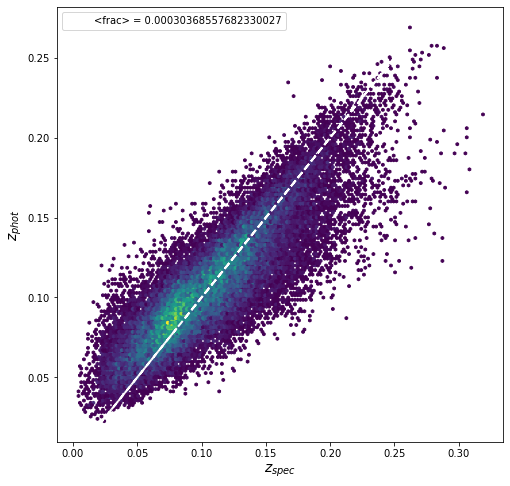

In [53]:
# remaking Figure 3 from Dey et al. 2022

plt.figure(figsize=[8,8])
plt.hexbin(test_set.z, zphot, mincnt=1, gridsize=150)
plt.plot(z, z, linestyle='--', color='white', lw=2, label=('<frac> = ' + str(np.mean(frac))))
plt.xlabel(r'$z_{spec}$', fontsize=14)
plt.ylabel(r'$z_{phot}$', fontsize=14)
plt.legend(loc='upper left')
plt.show()

# Didn't have enough time to try and make the bounding lines as in Fig. 3 :( 
# But broadly speaking this seems to have improved the fit compared to last time
# This is an interesting project because you assume your spec-z's are right, so
# it's really easy to confirm whether your random forest is doing its job. Which
# to some appreciable degree, seems that mine is not horrible!

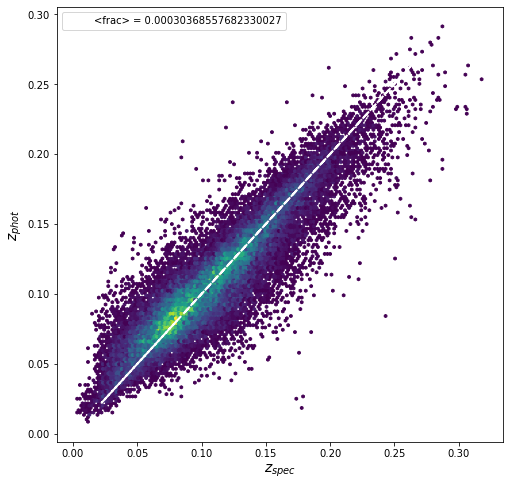

In [54]:
# remaking Figure 3 from Dey et al. 2022 (using prediction included in file for photo-z)

plt.figure(figsize=[8,8])
plt.hexbin(test_set.z, test_set.zphot, mincnt=1, gridsize=150)
plt.plot(z, z, linestyle='--', color='white', lw=2, label=('<frac> = ' + str(np.mean(frac))))
plt.xlabel(r'$z_{spec}$', fontsize=14)
plt.ylabel(r'$z_{phot}$', fontsize=14)
plt.legend(loc='upper left')
plt.show()

# Shouldn't take a genius to see that the photo-z prediction included in the test_set file is 
# pretty freaking good. But I think it's possible to get mine nearly as good as this, with more 
# time and maybe by changing the features that are currenly being trained. 

# But yeah, their prediction is better than mine. Oh well

Text(0, 0.5, 'Relative frequency')

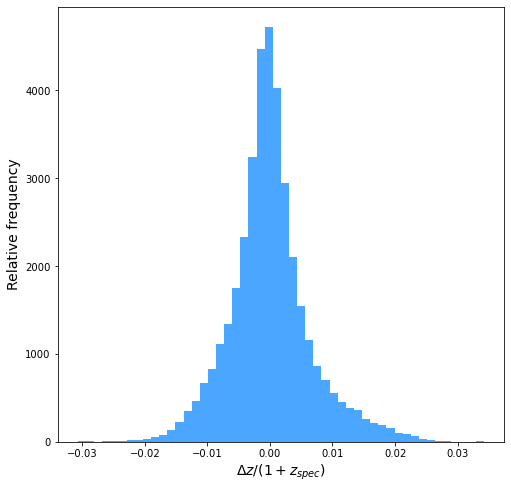

In [55]:
# Lo-fi version of Figure 4 from Dey et al. 2022

plt.figure(figsize=[8,8])
plt.hist(frac - np.mean(frac), bins=50, color='dodgerblue', alpha=0.8) #normalized this by subtracting all values from the mean, not sure if this is right
plt.xlabel(r'$\Delta z / (1 + z_{spec}$)', fontsize=14)
plt.ylabel('Relative frequency', fontsize=14)

# I get a somewhat Gaussian distribution like they did, but the methodology here is much simpler. 
# Also for whatever reason, the values on the y-axis are much higher, but I'm not putting much 
# stock into that. Lol

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-2.0, 2.0)

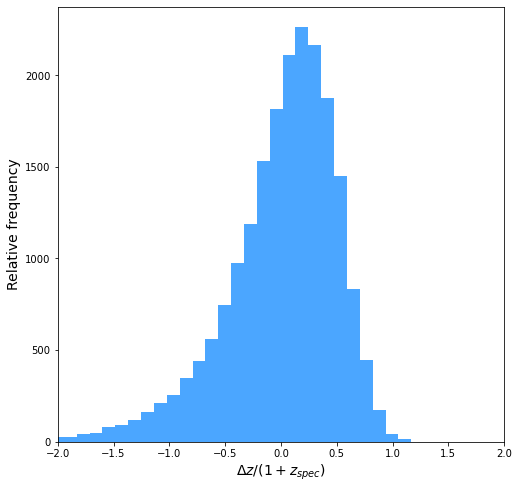

In [56]:
# Lo-fi version of Figure 4 from Dey et al. 2022 (using the actual data)

actual_frac = (test_set.zphot - test_set.z) / (1 + test_set.z)

plt.figure(figsize=[8,8])
plt.hist(np.log10(actual_frac) - np.mean(np.log10(actual_frac)), bins=50, color='dodgerblue', alpha=0.8) #normalized this by subtracting all values from the mean, not sure if this is right
plt.xlabel(r'$\Delta z / (1 + z_{spec}$)', fontsize=14)
plt.ylabel('Relative frequency', fontsize=14)
plt.xlim(-2, 2)

# Weirdly this doesn't look very gaussian... why doesn't look like
# Figure 4 from Dey et al? I did the math right (i think)